In [2]:
import tensorflow as tf
from tensorflow import keras
import pickle
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [13]:
model = keras.models.Sequential(name="YogaNet")
model.add(keras.layers.TimeDistributed(keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu"), input_shape=(45, 33, 2), name="Conv1D"))
model.add(keras.layers.TimeDistributed(keras.layers.BatchNormalization(), name="BatchNormalization_1"))
model.add(keras.layers.TimeDistributed(keras.layers.Dropout(rate=0.5), name="Dropout"))
model.add(keras.layers.TimeDistributed(keras.layers.BatchNormalization(), name="BatchNormalization_2"))
model.add(keras.layers.TimeDistributed(keras.layers.Flatten(), name="Flatten"))
model.add(keras.layers.LSTM(units=20, unit_forget_bias=True, return_sequences=True, name="LSTM"))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=6, activation="softmax"), name="Dense"))
model.add(keras.layers.GlobalAveragePooling1D(name="GlobalAveragePooling1D"))

In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
model.summary()

Model: "YogaNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D (TimeDistributed)    (None, 45, 31, 16)        112       
                                                                 
 BatchNormalization_1 (TimeD  (None, 45, 31, 16)       64        
 istributed)                                                     
                                                                 
 Dropout (TimeDistributed)   (None, 45, 31, 16)        0         
                                                                 
 BatchNormalization_2 (TimeD  (None, 45, 31, 16)       64        
 istributed)                                                     
                                                                 
 Flatten (TimeDistributed)   (None, 45, 496)           0         
                                                                 
 LSTM (LSTM)                 (None, 45, 20)            4136

In [5]:
labels = np.array(["Bhujangaasan", "Padmaasan", "Shavaasan", "Taadaasan", "Trikonaasan", "Vrikshaasan"])

In [6]:
def concat_datasets(datasets):
    concatenated_dataset = datasets[0]
    for dataset in datasets[1:]:
        concatenated_dataset = concatenated_dataset.concatenate(dataset)
    return concatenated_dataset

def generator(datasets):
    random.shuffle(datasets)
    for dataset in datasets:
        for x, y in dataset:
            yield x, y

In [3]:
with open("dataset.pkl", "rb") as f:
    data = pickle.load(f)
ann = pd.read_csv("train-val-test-annotations.csv")

In [8]:
folder = "batch_size_1_avg"
os.mkdir(f"runs\\{folder}")

In [7]:
batch_size = 1

In [8]:
train_datasets = []
val_datasets = []
test_datasets = []

for i in range(len(ann)):
    vid = data[i]
    targets = tf.one_hot([ann.iloc[i, 1]] * len(vid), 6)
    temp_dataset = keras.utils.timeseries_dataset_from_array(data=vid, targets=targets, sequence_length=45, sequence_stride=9, batch_size=batch_size)
    if ann.iloc[i, 2] == "train":
        train_datasets.append(temp_dataset)
    elif ann.iloc[i, 2] == "val":
        val_datasets.append(temp_dataset)
    else:
        test_datasets.append(temp_dataset)

# X and y represent input and output for the model here, not the coords of a keypoint
element_spec = temp_dataset.element_spec
x_spec = tf.TensorSpec(shape=element_spec[0].shape, dtype=element_spec[0].dtype)
y_spec = tf.TensorSpec(shape=element_spec[1].shape, dtype=element_spec[1].dtype)
output_signature = (x_spec, y_spec)
train_dataset = tf.data.Dataset.from_generator(lambda: generator(train_datasets), output_signature=output_signature)
val_dataset = tf.data.Dataset.from_generator(lambda: generator(val_datasets), output_signature=output_signature)
test_dataset = concat_datasets(test_datasets)

NameError: name 'concat_datasets' is not defined

In [10]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50
8190/8190 [==============================] - 111s 12ms/step - loss: 0.2333 - accuracy: 0.9457 - val_loss: 0.2843 - val_accuracy: 0.9548
Epoch 2/50
8190/8190 [==============================] - 93s 11ms/step - loss: 0.0792 - accuracy: 0.9795 - val_loss: 0.5350 - val_accuracy: 0.7934
Epoch 3/50
8190/8190 [==============================] - 90s 11ms/step - loss: 0.0291 - accuracy: 0.9929 - val_loss: 0.6695 - val_accuracy: 0.7292
Epoch 4/50
8190/8190 [==============================] - 90s 11ms/step - loss: 0.0205 - accuracy: 0.9949 - val_loss: 0.3265 - val_accuracy: 0.7929
Epoch 5/50
8190/8190 [==============================] - 90s 11ms/step - loss: 0.0318 - accuracy: 0.9900 - val_loss: 0.0908 - val_accuracy: 0.9728
Epoch 6/50
8190/8190 [==============================] - 91s 11ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0412 - val_accuracy: 0.9893
Epoch 7/50
8190/8190 [==============================] - 92s 11ms/step - loss: 0.0175 - accuracy: 0.9940 - val_loss: 0.1362 

In [11]:
model.save(f"runs\\{folder}\\model")

INFO:tensorflow:Assets written to: runs\batch_size_1_avg\model\assets


INFO:tensorflow:Assets written to: runs\batch_size_1_avg\model\assets


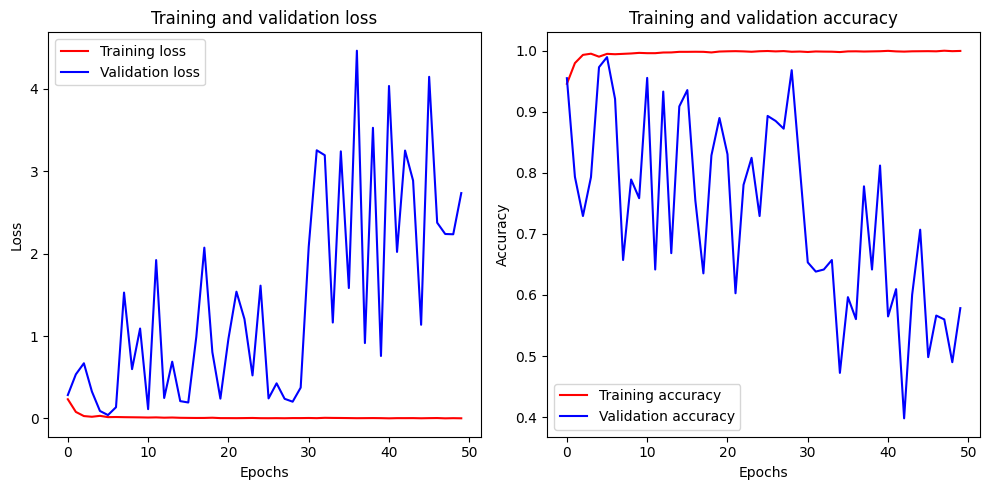

In [12]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(len(loss_values))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epochs, loss_values, 'r', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc_values, 'r', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig(f"runs\\{folder}\\loss_and_accuracy.png")

In [13]:
loss, acc = model.evaluate(test_dataset)
with open(f"runs\\{folder}\\test_results.txt", "w") as f:
    f.write(f"Loss: {loss}\nAccuracy: {acc}\n")

2573/2573 [==============================] - 14s 5ms/step - loss: 2.9404 - accuracy: 0.5632


2573/2573 [==============================] - 12s 5ms/step


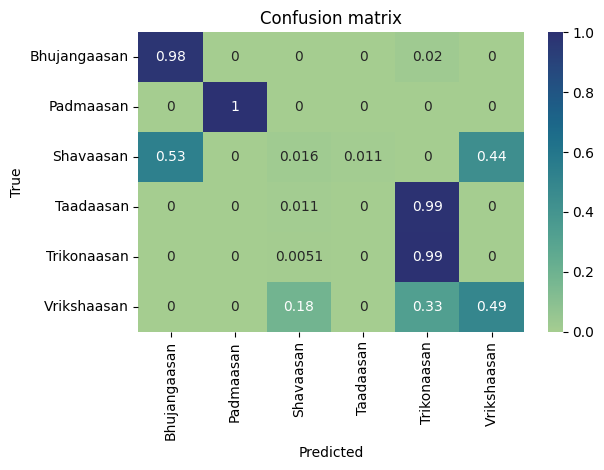

In [14]:
pred = model.predict(test_dataset)

true = []
for batch in test_dataset:
    for i in batch[1]:
        true.append(i.numpy())
true = np.array(true)

y_true = np.argmax(true, axis=1)
y_pred = np.argmax(pred, axis=1)
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_mat_normalized, annot=True, xticklabels=labels, yticklabels=labels, cmap="crest")
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.savefig(f"runs\\{folder}\\confusion_matrix.png")